In [3]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

%matplotlib notebook

In [4]:
import qcodes as qc

# Setup notes

For this example to run, you need to have set up a labpython config file. There is a template in labpythonQDelft/templates.

In [35]:
from importlib import reload
from qctools import instruments as instools
reload(instools)

import labpythonconfig as cfg
reload(cfg)

from experiment import measurement
reload(measurement)
from experiment.measurement import Parameter, BaseMeasurement

In [9]:
station = qc.Station()

In [18]:
class DummyMeasurement(BaseMeasurement):
    def __init__(self, station):
        super().__init__(station)
        
        self.add_parameter('start', Parameter)
        self.add_parameter('stop', Parameter)
        self.add_parameter('npts', Parameter)
    
    def measure(self):
        # initialize the data we need
        xpoints = np.linspace(self.start(), self.stop(), self.npts())
        data = xr.DataArray(np.zeros_like(xpoints),
                            coords=[('xpoints', xpoints)])
        self.dataset['data'] = data
        self.save_data()
        
        # now populate in a primitive loop
        for i, x in enumerate(xpoints):
            
            # acquire some data, and save right away
            self.dataset['data'][i] = np.cos(x)
            self.save_data()
                    

m = DummyMeasurement(station)
m.start(0)
m.stop(10)
m.npts(101)
m.run()

In [19]:
fn = m.datafilepath
print(fn)

c:\data\2017-12\2017-12-18\2017-12-18_DummyMeasurement-#0001.hdf5


In [20]:
with xr.open_dataset(fn) as ds:
    y = ds['data'].values
    x = ds['data'].coords['xpoints'].values

<IPython.core.display.Javascript object>


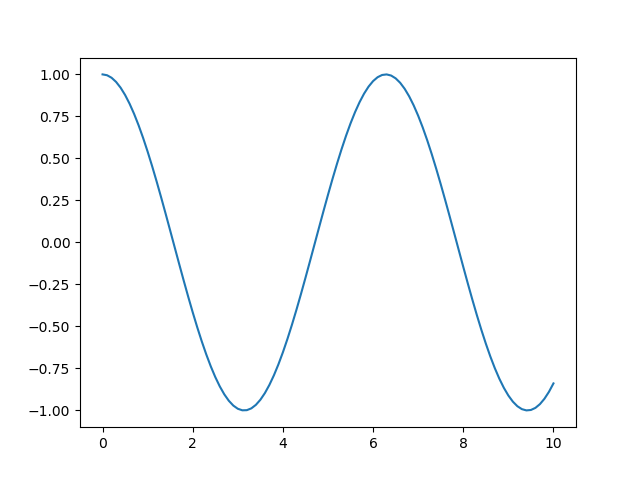

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(x, y)

In [27]:
voltage1 = 0
voltage2 = 0

def getv1():
    global voltage1
    return voltage1

def setv1(v):
    global voltage1
    voltage1 = v

def getv2():
    global voltage2
    return voltage2

def setv2(v):
    global voltage2
    voltage2 = v

v1 = qc.Parameter('voltage1', get_cmd=getv1, set_cmd=setv1)
v2 = qc.Parameter('voltage2', get_cmd=getv2, set_cmd=setv2)

station = qc.Station(v1, v2)

In [71]:
from pysweep import sweep_object
reload(sweep_object)
from pysweep.sweep_object import sweep, ChainSweep

class SimplePysweepMeasurement(BaseMeasurement):
    """
    A simple prototype for how we could write a measurement around pysweep loops.
    so far this only working for some, regular-gridded sweeps.
    
    The idea here is that when inheriting from this, the user only needs to specify the
    sweep and acquire methods. The measure methods should just work for all sweeps.
    Importantly, the data allocation is taken out of the user's hands here.
    """
    
    def measure(self):
        # analyze the sweep
        # TODO: this only works for certain sweep structures so far
        # TODO: need a good way to recognize if a sweep dimension size is unknown so far
        #       in that case the measurement needs to extend it as data comes in
        sweep = self.sweep()
        shp = sweep.shape
        print('data shape: ', shp)
        coords = sweep.coords
        print('data coords: ', coords)
        
        # knowing the dimension allows us to allocate a dataset
        # this only works for scalar data.
        # if the acquire methods returns an array, then we would have to wait
        # with allocation until we know the returned shape (depends on class implementation)
        data = xr.DataArray(np.zeros(shp), coords=coords)
        self.dataset['data'] = data
        self.save_data()
        
        # this is not very elegant, but since i don't really know 'where' in the
        # sweep pysweep currently is, this is the easiest i could come up with.
        # this line generates the n-d array indices in the order that the sweep loops through the coordinates.
        idxs = zip(*[ idx.reshape(-1) for idx in np.meshgrid(*[np.arange(c[1].size) for c in coords], indexing='ij') ])
        
        for idx, data in zip(idxs, sweep):
            data_val = data['data']['value']
            print(idx, self.station.voltage1(), self.station.voltage2(), data_val)
            
            self.dataset['data'][idx] = data_val
            self.save_data()
        
    
    # These are examples -- will be implemented by the user.
    def acquire(self, station, namespace):
        return {'data' : {'value' : self.station.voltage1() * self.station.voltage2()**2 }}
        
    def sweep(self):
        return ChainSweep([
            sweep(self.station.voltage1, np.linspace(0,1,3)) (
                sweep(self.station.voltage2, np.linspace(0,2,5)) (
                    self.acquire,
                )
            )
        ])
    

m = SimplePysweepMeasurement(station)
m.run()

data shape:  (3, 5)
data coords:  [('voltage1', array([ 0. ,  0.5,  1. ])), ('voltage2', array([ 0. ,  0.5,  1. ,  1.5,  2. ]))]
(0, 0) 0.0 0.0 0.0
(0, 1) 0.0 0.5 0.0
(0, 2) 0.0 1.0 0.0
(0, 3) 0.0 1.5 0.0
(0, 4) 0.0 2.0 0.0
(1, 0) 0.5 0.0 0.0
(1, 1) 0.5 0.5 0.125
(1, 2) 0.5 1.0 0.5
(1, 3) 0.5 1.5 1.125
(1, 4) 0.5 2.0 2.0
(2, 0) 1.0 0.0 0.0
(2, 1) 1.0 0.5 0.25
(2, 2) 1.0 1.0 1.0
(2, 3) 1.0 1.5 2.25
(2, 4) 1.0 2.0 4.0


In [72]:
fn = m.datafilepath
print(fn)

c:\data\2017-12\2017-12-18\2017-12-18_SimplePysweepMeasurement-#0001.hdf5


In [73]:
with xr.open_dataset(fn) as ds:
    z = ds['data'].values
    v1 = ds['data'].coords['voltage1'].values
    v2 = ds['data'].coords['voltage2'].values

<IPython.core.display.Javascript object>


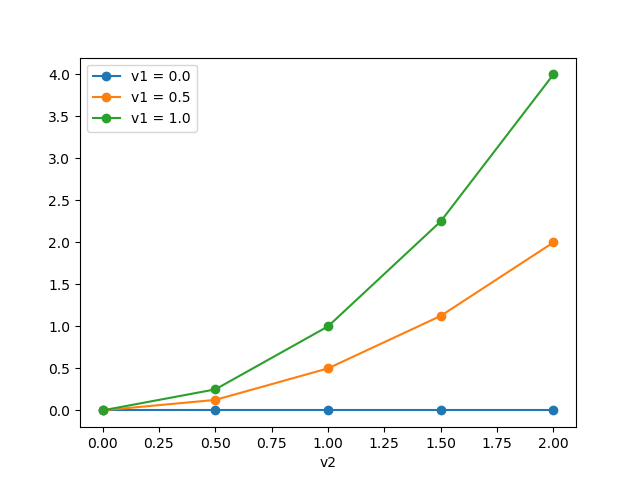

In [70]:
fig, ax = plt.subplots(1,1)
for i, v1val in enumerate(v1):
    ax.plot(v2, z[i, :], '-o', label='v1 = {}'.format(v1val))

ax.legend()
ax.set_xlabel("v2")